In [1]:
! nvidia-smi

Sat Aug  1 06:03:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.6.0+cu101


In [4]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.4 s, sys: 828 ms, total: 2.23 s
Wall time: 4 s


In [5]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [6]:
class_list       = [0,1,2,3]
class_names_dict = {0:'FB', 1:'LQ', 2:'SQ', 3:'WD'}
class_names      = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [7]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*0.7)},Test Data length: {int(len(dataset)*0.3)}')
train_len = int(len(dataset)*0.7)

Dataset Length:19318, Train Data length: 13522,Test Data length: 5795


In [8]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 335 (delta 43), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (335/335), 4.17 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [9]:
%cd '/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda'
! ls

/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda
EVA4P2_S2_MobilenetV2_V1.ipynb	EVA4P2_S2_MobilenetV2_V3.ipynb	src
EVA4P2_S2_MobilenetV2_V2.ipynb	README.md


In [10]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train_Losses
from src.losses  import Test_Losses
from src.utils   import Freeze_Layers as Freeze

In [11]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=56, max_w_size=56), # fillvalue is 0 after normalizing as mean is 0
                                    ])

#fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = Alb.Albumentations_transform([A.Resize(224, 224),
                                                A.Normalize(mean=channel_means, std=channel_stdevs),])

In [12]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}, Test Length {len(test)}')

Train Length 13522, Test Length 5796


In [13]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, pin_memory = True)
test_loader   = DataLoader(test, batch_size = 32, shuffle = True, pin_memory = True)

In [14]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [15]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 224, 224]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


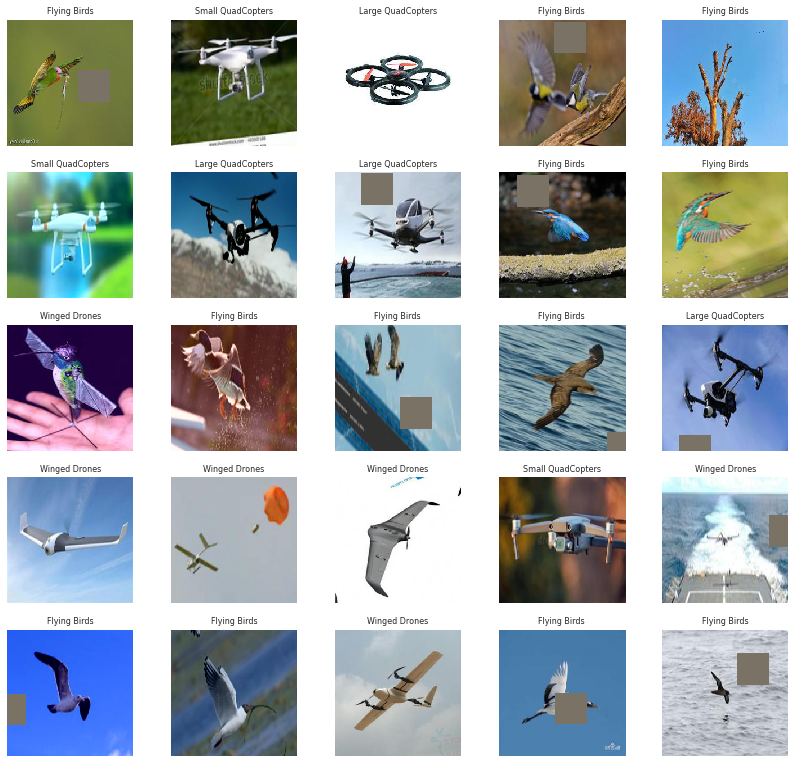

In [16]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()    

### Downloading Pretrained Mobilenet_V2 and displaying summary to understand the layers & corresponding parms

In [47]:
!pip install torchsummary
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=True)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


### Unfreezing only selected layers. Also customizing the FC layer to predict only 4 classes instead of 1000 classes (Mobilenet V2 is pretrained against imagenet which has 1000 classes)

In [48]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4).to("cuda")
model.features[16].requires_grad  = True
model.features[17].requires_grad  = True
model.features[18].requires_grad  = True
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

### Displaying Layerwise view to understand convolutions, BN, Relu etc. coming under each layer. Will help us to reach a decision in which layer to unfreeze

In [49]:
model.to(model.device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [50]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

### Displaying layer names against model. Will help us to customize/ unfreeze/ freeze selected layers

In [51]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: features
name: features.0
name: features.0.0
name: features.0.1
name: features.0.2
name: features.1
name: features.1.conv
name: features.1.conv.0
name: features.1.conv.0.0
name: features.1.conv.0.1
name: features.1.conv.0.2
name: features.1.conv.1
name: features.1.conv.2
name: features.2
name: features.2.conv
name: features.2.conv.0
name: features.2.conv.0.0
name: features.2.conv.0.1
name: features.2.conv.0.2
name: features.2.conv.1
name: features.2.conv.1.0
name: features.2.conv.1.1
name: features.2.conv.1.2
name: features.2.conv.2
name: features.2.conv.3
name: features.3
name: features.3.conv
name: features.3.conv.0
name: features.3.conv.0.0
name: features.3.conv.0.1
name: features.3.conv.0.2
name: features.3.conv.1
name: features.3.conv.1.0
name: features.3.conv.1.1
name: features.3.conv.1.2
name: features.3.conv.2
name: features.3.conv.3
name: features.4
name: features.4.conv
name: features.4.conv.0
name: features.4.conv.0.0
name: features.4.conv.0.1
name: features.4.c

#### Function to calculate class-wise accuracy

In [52]:
def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc

#### Command to load the model from saved model weights from previous training.

In [45]:
#path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0730V3.pt'
#model.load_state_dict(torch.load(path))
model = torch.jit.load(path_model_save)

#### Train & Test for fixed epochs. Will save the model in 2 situations:
#### 1) When LR reduces based on ReduceLROnPlateau 
#### 2) On final Epoch. 
#### We are using 'torch.jit.save' instead of 'torch.save' as former is compatible with any of the mobile platforms - not just python (dynamically typed) can run even in platforms built in C which is statically typed programming languages

In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 50
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []
prev_lr_value  = least_loss_lr

OPTIMIZER = optim.SGD(model.parameters(),lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min',factor=0.1, min_lr=1e-10, patience =4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
  print('\nEPOCH:', epoch)
  train_losses, train_acc, lr_value = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                       epoch=EPOCH, factor=L1_factor,criterion=criterion,
                                                       scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
  test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct, correct_predict, correct_pred_class, correct_act_class = \
                            test_loss.test_loss_calc(model,model.device,test_loader=test_loader,optimizer=OPTIMIZER,
                                                     total_epoch=EPOCH,current_epoch=epoch,criterion=criterion,
                                                     scheduler=SCHEDULER) 
  train_loss_all.extend(train_losses)
  train_acc_all.extend(train_acc)
  test_loss_all.extend(test_losses)
  test_acc_all.extend(test_acc)
  
  loss_decrease = 0  
  if len(test_loss_all) > 1:    
    loss_decrease = test_loss_all[-2] - test_loss_all[-1]
    if loss_decrease > 0:
      print(f'Test Loss -> Decreasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')
    else:
      print(f'Test Loss -> Increasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')

  if lr_value < prev_lr_value:           ### Save the model values if loss values stabilized significantly
    script_module = torch.jit.script(model) 
    path_model_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0801V2.pt'
    torch.jit.save(script_module, path_model_save)
    print(f' **** Model Stable, hence Saved in epoch:{epoch} Prev Lr:{prev_lr_value} New Lr:{lr_value}:{path_model_save}')    
  
  prev_lr_value = lr_value

  if epoch == (EPOCH - 1):              ### Save the model values on final epoch
    script_module = torch.jit.script(model) 
    path_model_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_0801V2.pt'
    torch.jit.save(script_module, path_model_save)    
    print(f' **** Model Saved in Final epoch:{epoch} Lr Value:{lr_value} :{path_model_save}')

    classwise_acc = calc_classwiseacc(label_total,label_correct)
    class_acc_all.append(classwise_acc)  

Train Loss = 1.5011967420578003 Batch Id = 0 Train Acc = 21.88 LR =0.030000:   0%|          | 1/423 [00:00<01:05,  6.41it/s]


EPOCH: 0


Train Loss = 1.8249374628067017 Batch Id = 422 Train Acc = 69.38 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.17it/s]
Train Loss = 0.7830051183700562 Batch Id = 0 Train Acc = 84.38 LR =0.030000:   0%|          | 1/423 [00:00<01:03,  6.61it/s]


Test set: Average loss: 0.0408, Test Accuracy: 75.86, LR : 0.030000

EPOCH: 1


Train Loss = 1.4594968557357788 Batch Id = 422 Train Acc = 71.13 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.14it/s]
Train Loss = 1.9440958499908447 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<01:01,  6.86it/s]


Test set: Average loss: 0.0631, Test Accuracy: 72.72, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.040823, Latest Loss:0.063128, Delta:-0.022305

EPOCH: 2


Train Loss = 0.24532675743103027 Batch Id = 422 Train Acc = 71.56 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.13it/s]
Train Loss = 3.154294013977051 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<00:59,  7.07it/s]


Test set: Average loss: 0.0634, Test Accuracy: 73.07, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.063128, Latest Loss:0.063434, Delta:-0.000305

EPOCH: 3


Train Loss = 1.515409231185913 Batch Id = 422 Train Acc = 71.99 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.18it/s]
Train Loss = 1.5236974954605103 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<01:00,  7.03it/s]


Test set: Average loss: 0.0383, Test Accuracy: 76.81, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.063434, Latest Loss:0.038343, Delta:0.025090

EPOCH: 4


Train Loss = 1.2078114748001099 Batch Id = 422 Train Acc = 71.48 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.23it/s]
Train Loss = 1.6751784086227417 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<01:01,  6.91it/s]


Test set: Average loss: 0.0383, Test Accuracy: 79.54, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.038343, Latest Loss:0.038332, Delta:0.000012

EPOCH: 5


Train Loss = 2.229421615600586 Batch Id = 422 Train Acc = 72.12 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.14it/s]
Train Loss = 1.447016716003418 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<01:01,  6.84it/s]


Test set: Average loss: 0.0599, Test Accuracy: 74.15, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.038332, Latest Loss:0.059948, Delta:-0.021616

EPOCH: 6


Train Loss = 1.7799162864685059 Batch Id = 422 Train Acc = 72.00 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.09it/s]
Train Loss = 4.093146324157715 Batch Id = 0 Train Acc = 62.50 LR =0.030000:   0%|          | 1/423 [00:00<01:04,  6.50it/s]


Test set: Average loss: 0.0751, Test Accuracy: 72.46, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.059948, Latest Loss:0.075147, Delta:-0.015199

EPOCH: 7


Train Loss = 2.9788403511047363 Batch Id = 422 Train Acc = 72.23 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.17it/s]
Train Loss = 1.292240023612976 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<01:06,  6.38it/s]


Test set: Average loss: 0.0445, Test Accuracy: 78.30, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.075147, Latest Loss:0.044499, Delta:0.030648

EPOCH: 8


Train Loss = 0.2284879982471466 Batch Id = 422 Train Acc = 71.71 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.17it/s]
Train Loss = 3.045797109603882 Batch Id = 0 Train Acc = 68.75 LR =0.030000:   0%|          | 1/423 [00:00<01:00,  6.95it/s]


Test set: Average loss: 0.0419, Test Accuracy: 77.78, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.044499, Latest Loss:0.041873, Delta:0.002626

EPOCH: 9


Train Loss = 3.5329055786132812 Batch Id = 422 Train Acc = 72.58 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.16it/s]
Train Loss = 1.3446649312973022 Batch Id = 0 Train Acc = 84.38 LR =0.030000:   0%|          | 1/423 [00:00<01:03,  6.68it/s]


Test set: Average loss: 0.0329, Test Accuracy: 80.07, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.041873, Latest Loss:0.032872, Delta:0.009001

EPOCH: 10


Train Loss = 4.947088241577148 Batch Id = 422 Train Acc = 71.91 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.15it/s]
Train Loss = 1.6776267290115356 Batch Id = 0 Train Acc = 84.38 LR =0.030000:   0%|          | 1/423 [00:00<01:00,  6.93it/s]


Test set: Average loss: 0.0403, Test Accuracy: 78.02, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.032872, Latest Loss:0.040327, Delta:-0.007454

EPOCH: 11


Train Loss = 3.0771398544311523 Batch Id = 422 Train Acc = 72.96 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.14it/s]
Train Loss = 0.8124043345451355 Batch Id = 0 Train Acc = 87.50 LR =0.030000:   0%|          | 1/423 [00:00<00:57,  7.31it/s]


Test set: Average loss: 0.0400, Test Accuracy: 78.19, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.040327, Latest Loss:0.039977, Delta:0.000350

EPOCH: 12


Train Loss = 3.7706069946289062 Batch Id = 422 Train Acc = 72.96 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.11it/s]
Train Loss = 3.021733522415161 Batch Id = 0 Train Acc = 68.75 LR =0.030000:   0%|          | 1/423 [00:00<00:57,  7.30it/s]


Test set: Average loss: 0.0468, Test Accuracy: 77.40, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.039977, Latest Loss:0.046829, Delta:-0.006852

EPOCH: 13


Train Loss = 1.712550163269043 Batch Id = 422 Train Acc = 73.13 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.12it/s]
Train Loss = 2.41658091545105 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<01:01,  6.84it/s]


Test set: Average loss: 0.0579, Test Accuracy: 76.74, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.046829, Latest Loss:0.057909, Delta:-0.011080

EPOCH: 14


Train Loss = 1.0731297731399536 Batch Id = 422 Train Acc = 72.52 LR =0.030000: 100%|██████████| 423/423 [00:59<00:00,  7.14it/s]
Train Loss = 4.01703405380249 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.13it/s]

Epoch    15: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.0931, Test Accuracy: 73.00, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.057909, Latest Loss:0.093085, Delta:-0.035176

EPOCH: 15


Train Loss = 0.8536849021911621 Batch Id = 422 Train Acc = 75.04 LR =0.003000: 100%|██████████| 423/423 [00:58<00:00,  7.19it/s]



Test set: Average loss: 0.0231, Test Accuracy: 81.45, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.093085, Latest Loss:0.023140, Delta:0.069945


Train Loss = 1.4431343078613281 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<01:02,  6.77it/s]

 **** Model Stable, hence Saved in epoch:15 Prev Lr:0.03 New Lr:0.003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0801V2.pt

EPOCH: 16


Train Loss = 1.32160484790802 Batch Id = 422 Train Acc = 75.62 LR =0.003000: 100%|██████████| 423/423 [00:58<00:00,  7.20it/s]
Train Loss = 0.800125777721405 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<01:01,  6.92it/s]


Test set: Average loss: 0.0207, Test Accuracy: 81.45, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.023140, Latest Loss:0.020723, Delta:0.002417

EPOCH: 17


Train Loss = 1.07753324508667 Batch Id = 422 Train Acc = 76.00 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.38it/s]
Train Loss = 0.8797935247421265 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<01:03,  6.65it/s]


Test set: Average loss: 0.0184, Test Accuracy: 81.82, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.020723, Latest Loss:0.018415, Delta:0.002308

EPOCH: 18


Train Loss = 1.46687912940979 Batch Id = 422 Train Acc = 75.50 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.34it/s]
Train Loss = 0.7385954856872559 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.14it/s]


Test set: Average loss: 0.0180, Test Accuracy: 81.73, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.018415, Latest Loss:0.018029, Delta:0.000385

EPOCH: 19


Train Loss = 0.6153146624565125 Batch Id = 422 Train Acc = 75.80 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.39it/s]
Train Loss = 0.8515335321426392 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.26it/s]


Test set: Average loss: 0.0190, Test Accuracy: 80.49, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.018029, Latest Loss:0.019043, Delta:-0.001014

EPOCH: 20


Train Loss = 1.259801983833313 Batch Id = 422 Train Acc = 76.09 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.32it/s]
Train Loss = 0.7358261346817017 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.18it/s]


Test set: Average loss: 0.0164, Test Accuracy: 81.54, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.019043, Latest Loss:0.016414, Delta:0.002629

EPOCH: 21


Train Loss = 0.401830792427063 Batch Id = 422 Train Acc = 76.90 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.38it/s]
Train Loss = 0.9742105007171631 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.04it/s]


Test set: Average loss: 0.0166, Test Accuracy: 81.40, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.016414, Latest Loss:0.016639, Delta:-0.000225

EPOCH: 22


Train Loss = 0.8285760879516602 Batch Id = 422 Train Acc = 75.51 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.33it/s]
Train Loss = 0.5081506371498108 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.10it/s]


Test set: Average loss: 0.0168, Test Accuracy: 81.11, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.016639, Latest Loss:0.016843, Delta:-0.000204

EPOCH: 23


Train Loss = 0.5728251934051514 Batch Id = 422 Train Acc = 76.56 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.33it/s]
Train Loss = 0.5273036956787109 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.50it/s]


Test set: Average loss: 0.0146, Test Accuracy: 82.82, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.016843, Latest Loss:0.014575, Delta:0.002268

EPOCH: 24


Train Loss = 0.6985529661178589 Batch Id = 422 Train Acc = 76.39 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.37it/s]
Train Loss = 0.8115841150283813 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<01:01,  6.92it/s]


Test set: Average loss: 0.0146, Test Accuracy: 82.30, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014575, Latest Loss:0.014639, Delta:-0.000064

EPOCH: 25


Train Loss = 0.8659831285476685 Batch Id = 422 Train Acc = 76.49 LR =0.003000: 100%|██████████| 423/423 [00:58<00:00,  7.22it/s]
Train Loss = 0.9378464221954346 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<01:00,  6.98it/s]


Test set: Average loss: 0.0152, Test Accuracy: 81.61, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014639, Latest Loss:0.015182, Delta:-0.000543

EPOCH: 26


Train Loss = 0.5192840695381165 Batch Id = 422 Train Acc = 77.01 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.34it/s]
Train Loss = 0.7847976684570312 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.25it/s]


Test set: Average loss: 0.0148, Test Accuracy: 82.26, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015182, Latest Loss:0.014781, Delta:0.000401

EPOCH: 27


Train Loss = 1.0487010478973389 Batch Id = 422 Train Acc = 76.99 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.34it/s]
Train Loss = 0.7298534512519836 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.29it/s]


Test set: Average loss: 0.0142, Test Accuracy: 82.26, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014781, Latest Loss:0.014165, Delta:0.000617

EPOCH: 28


Train Loss = 1.2556650638580322 Batch Id = 422 Train Acc = 77.53 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.35it/s]
Train Loss = 0.5991979241371155 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.38it/s]


Test set: Average loss: 0.0152, Test Accuracy: 80.99, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014165, Latest Loss:0.015166, Delta:-0.001001

EPOCH: 29


Train Loss = 1.368268609046936 Batch Id = 422 Train Acc = 77.18 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.38it/s]
Train Loss = 0.7585617303848267 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<01:01,  6.89it/s]


Test set: Average loss: 0.0146, Test Accuracy: 81.16, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015166, Latest Loss:0.014553, Delta:0.000613

EPOCH: 30


Train Loss = 0.9976867437362671 Batch Id = 422 Train Acc = 77.56 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.33it/s]
Train Loss = 0.8129752278327942 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.42it/s]


Test set: Average loss: 0.0137, Test Accuracy: 83.01, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014553, Latest Loss:0.013689, Delta:0.000864

EPOCH: 31


Train Loss = 0.9560592174530029 Batch Id = 422 Train Acc = 76.80 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.38it/s]
Train Loss = 0.8513714671134949 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.38it/s]


Test set: Average loss: 0.0135, Test Accuracy: 82.57, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013689, Latest Loss:0.013542, Delta:0.000147

EPOCH: 32


Train Loss = 0.6309879422187805 Batch Id = 422 Train Acc = 77.73 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.39it/s]
Train Loss = 1.258258581161499 Batch Id = 0 Train Acc = 62.50 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.31it/s]


Test set: Average loss: 0.0142, Test Accuracy: 81.76, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013542, Latest Loss:0.014186, Delta:-0.000644

EPOCH: 33


Train Loss = 0.5829640030860901 Batch Id = 422 Train Acc = 77.10 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.39it/s]
Train Loss = 0.5752502679824829 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.29it/s]


Test set: Average loss: 0.0137, Test Accuracy: 82.47, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014186, Latest Loss:0.013698, Delta:0.000488

EPOCH: 34


Train Loss = 0.9028022885322571 Batch Id = 422 Train Acc = 77.70 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.41it/s]
Train Loss = 0.8742655515670776 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.15it/s]


Test set: Average loss: 0.0140, Test Accuracy: 82.19, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013698, Latest Loss:0.013974, Delta:-0.000276

EPOCH: 35


Train Loss = 0.2473621368408203 Batch Id = 422 Train Acc = 76.84 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 0.6623501181602478 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.35it/s]


Test set: Average loss: 0.0137, Test Accuracy: 82.83, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013974, Latest Loss:0.013735, Delta:0.000239

EPOCH: 36


Train Loss = 0.8287938833236694 Batch Id = 422 Train Acc = 77.26 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.42it/s]
Train Loss = 0.5375114679336548 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<00:57,  7.39it/s]

Epoch    37: reducing learning rate of group 0 to 3.0000e-04.

Test set: Average loss: 0.0139, Test Accuracy: 83.01, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013735, Latest Loss:0.013938, Delta:-0.000203

EPOCH: 37


Train Loss = 0.9762126803398132 Batch Id = 422 Train Acc = 78.64 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.43it/s]



Test set: Average loss: 0.0134, Test Accuracy: 82.95, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013938, Latest Loss:0.013356, Delta:0.000582


Train Loss = 0.7148114442825317 Batch Id = 0 Train Acc = 81.25 LR =0.000300:   0%|          | 1/423 [00:00<01:00,  6.94it/s]

 **** Model Stable, hence Saved in epoch:37 Prev Lr:0.003 New Lr:0.00030000000000000003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0801V2.pt

EPOCH: 38


Train Loss = 0.5607608556747437 Batch Id = 422 Train Acc = 78.58 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 0.7076506018638611 Batch Id = 0 Train Acc = 71.88 LR =0.000300:   0%|          | 1/423 [00:00<01:03,  6.64it/s]


Test set: Average loss: 0.0133, Test Accuracy: 82.95, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013356, Latest Loss:0.013321, Delta:0.000035

EPOCH: 39


Train Loss = 0.3816148042678833 Batch Id = 422 Train Acc = 78.90 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.43it/s]
Train Loss = 0.6832547187805176 Batch Id = 0 Train Acc = 65.62 LR =0.000300:   0%|          | 1/423 [00:00<00:58,  7.20it/s]


Test set: Average loss: 0.0133, Test Accuracy: 83.02, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013321, Latest Loss:0.013281, Delta:0.000040

EPOCH: 40


Train Loss = 1.3301764726638794 Batch Id = 422 Train Acc = 78.60 LR =0.000300: 100%|██████████| 423/423 [00:57<00:00,  7.40it/s]
Train Loss = 0.4835043251514435 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<01:02,  6.73it/s]


Test set: Average loss: 0.0134, Test Accuracy: 83.14, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013281, Latest Loss:0.013369, Delta:-0.000088

EPOCH: 41


Train Loss = 0.6249173283576965 Batch Id = 422 Train Acc = 78.64 LR =0.000300: 100%|██████████| 423/423 [00:57<00:00,  7.40it/s]
Train Loss = 0.48742589354515076 Batch Id = 0 Train Acc = 84.38 LR =0.000300:   0%|          | 1/423 [00:00<00:58,  7.25it/s]


Test set: Average loss: 0.0134, Test Accuracy: 83.42, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013369, Latest Loss:0.013405, Delta:-0.000036

EPOCH: 42


Train Loss = 0.724236786365509 Batch Id = 422 Train Acc = 78.92 LR =0.000300: 100%|██████████| 423/423 [00:57<00:00,  7.38it/s]
Train Loss = 0.6206807494163513 Batch Id = 0 Train Acc = 68.75 LR =0.000300:   0%|          | 1/423 [00:00<00:59,  7.12it/s]


Test set: Average loss: 0.0132, Test Accuracy: 83.23, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013405, Latest Loss:0.013180, Delta:0.000225

EPOCH: 43


Train Loss = 0.8573196530342102 Batch Id = 422 Train Acc = 79.06 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 0.5710503458976746 Batch Id = 0 Train Acc = 75.00 LR =0.000300:   0%|          | 1/423 [00:00<00:58,  7.18it/s]


Test set: Average loss: 0.0134, Test Accuracy: 83.20, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013180, Latest Loss:0.013368, Delta:-0.000188

EPOCH: 44


Train Loss = 0.5237391591072083 Batch Id = 422 Train Acc = 79.05 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.45it/s]
Train Loss = 0.5292317867279053 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<01:03,  6.61it/s]


Test set: Average loss: 0.0132, Test Accuracy: 82.99, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013368, Latest Loss:0.013208, Delta:0.000160

EPOCH: 45


Train Loss = 0.6489531397819519 Batch Id = 422 Train Acc = 78.78 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.45it/s]
Train Loss = 0.3512483239173889 Batch Id = 0 Train Acc = 84.38 LR =0.000300:   0%|          | 1/423 [00:00<01:00,  6.97it/s]


Test set: Average loss: 0.0132, Test Accuracy: 83.07, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013208, Latest Loss:0.013201, Delta:0.000007

EPOCH: 46


Train Loss = 0.6280384659767151 Batch Id = 422 Train Acc = 78.72 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 0.5293120741844177 Batch Id = 0 Train Acc = 87.50 LR =0.000300:   0%|          | 1/423 [00:00<00:56,  7.51it/s]


Test set: Average loss: 0.0131, Test Accuracy: 83.21, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013201, Latest Loss:0.013083, Delta:0.000118

EPOCH: 47


Train Loss = 0.6883038878440857 Batch Id = 422 Train Acc = 78.76 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.46it/s]
Train Loss = 0.38542479276657104 Batch Id = 0 Train Acc = 90.62 LR =0.000300:   0%|          | 1/423 [00:00<00:56,  7.47it/s]


Test set: Average loss: 0.0132, Test Accuracy: 82.73, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013083, Latest Loss:0.013187, Delta:-0.000104

EPOCH: 48


Train Loss = 0.45648348331451416 Batch Id = 422 Train Acc = 78.61 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 0.7567739486694336 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<00:58,  7.22it/s]


Test set: Average loss: 0.0132, Test Accuracy: 82.94, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013187, Latest Loss:0.013250, Delta:-0.000062

EPOCH: 49


Train Loss = 0.5758537650108337 Batch Id = 422 Train Acc = 79.43 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]



Test set: Average loss: 0.0133, Test Accuracy: 82.51, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013250, Latest Loss:0.013324, Delta:-0.000074
 **** Model Saved in Final epoch:49 Lr Value:0.00030000000000000003 :/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_0801V2.pt
Test accuracy for class -  0  -  FB  :  98.17 correct: 2247 Total: 2289
Test accuracy for class -  1  -  LQ  :  72.62 correct: 793 Total: 1092
Test accuracy for class -  2  -  SQ  :  53.0 correct: 451 Total: 851
Test accuracy for class -  3  -  WD  :  82.54 correct: 1291 Total: 1564
Total Test Images: 5796 Correct Images: 4782


#### Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

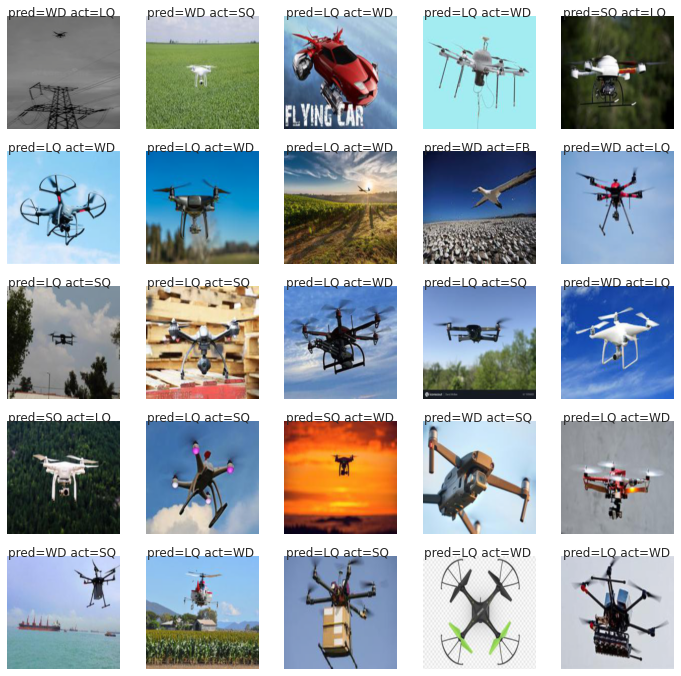

In [54]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Plotting correctly classified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

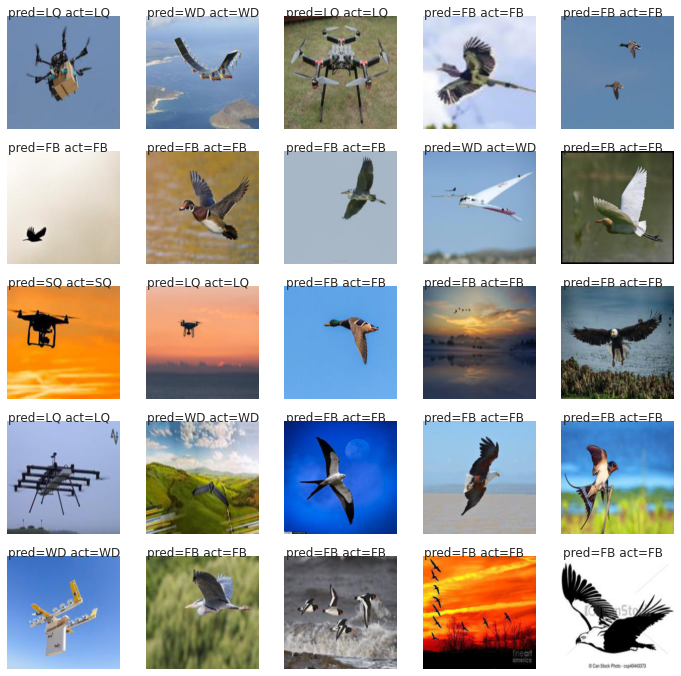

In [55]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(correct_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(correct_pred_class[i])
      actual     = class_names_dict.get(correct_act_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Train & Test accuracies, Test Losses & Train Losses

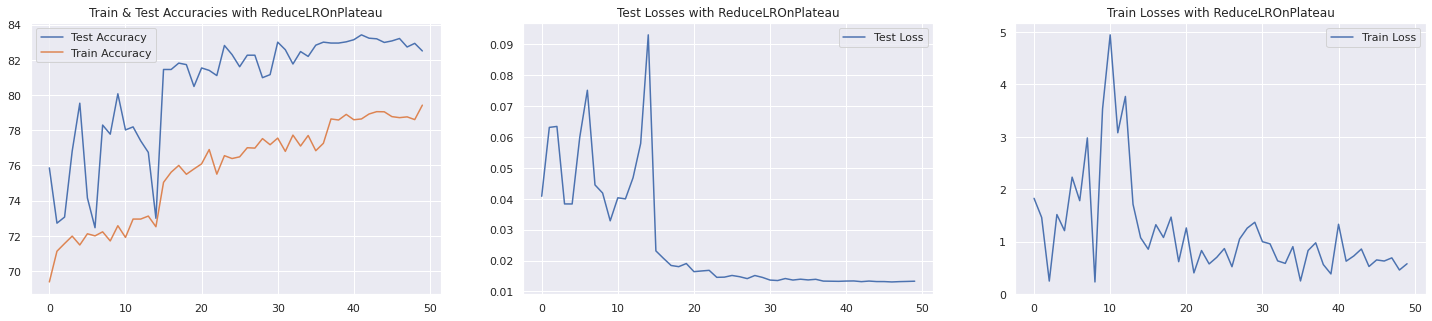

In [56]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")